In [21]:
#Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import networkx as nx

import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GATConv

from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter
from mplsoccer import FontManager, Sbopen, Pitch
import matplotlib.patheffects as path_effects

import community as community_louvain 

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 150)

#Read in sna data
sna_data = pd.read_excel('C:\\Users\\kpaul\\Documents\\Univeristy of Glasgow - MSc\\Semester 4 - Fall 2024\\Final Year Project\\Project Code\\sna_data_v1.xlsx')
sna_data.head()

,Unnamed: 0.1,Unnamed: 0,match_id,team_name,opposing_team,player_name,poistion,play_pattern,time,duration,passer_loc_x,passer_loc_y,under_pressure,pass_end_x,pass_end_y,pass_length,pass_angle,pass_recipient,pass_height_name,pass_body_part,pass_type,pass_cross,pass_switch,pass_through_ball,pass_goal_assist,pass_shot_assist,pass_outcome,pass_technique,player1,player1_x,player1_y,player2,player2_x,player2_y,player3,player3_x,player3_y,player4,player4_x,player4_y,player5,player5_x,player5_y,player6,player6_x,player6_y,player7,player7_x,player7_y,player8,player8_x,player8_y,player9,player9_x,player9_y,player10,player10_x,player10_y,player11,player11_x,player11_y,player12,player12_x,player12_y,player13,player13_x,player13_y,player14,player14_x,player14_y,player15,player15_x,player15_y,player16,player16_x,player16_y,player17,player17_x,player17_y,player18,player18_x,player18_y,player19,player19_x,player19_y,player20,player20_x,player20_y,player21,player21_x,player21_y,complete_prob
0,0,0,3893787,New Zealand Women's,Norway Women's,Jacqueline Anne Hand,Right Center Forward,From Kick Off,0:00,0.6,60.0,40.0,0,53.9,36.1,7.2,-2.6,Malia Grace Steinmetz,Ground Pass,Right Foot,Kick Off,0,0,0,0,0,1,Unknown,1,36.1,49.7,1,37.7,36.8,1,41.0,67.3,1,42.9,21.8,1,50.5,47.7,1,56.1,36.6,1,59.7,52.8,1,59.9,13.7,1,60.2,70.3,0,60.4,50.3,0,66.0,28.8,0,66.6,50.6,0,67.9,19.9,0,68.1,60.3,0,71.2,40.0,0,80.1,60.4,0,81.7,34.4,0,82.1,25.0,0,82.3,49.1,0,0.0,0.0,0,0,0,0.963375
1,1,1,3893787,New Zealand Women's,Norway Women's,Malia Grace Steinmetz,Left Defensive Midfield,From Kick Off,0:01,1.8,52.8,37.1,0,34.1,62.5,31.5,2.2,Catherine Joan Bott,Ground Pass,Right Foot,Normal,0,0,0,0,0,1,Unknown,1,34.1,48.9,1,35.3,35.2,1,37.7,64.5,1,43.6,19.6,1,49.8,45.6,0,54.6,40.5,1,58.3,16.1,0,61.3,28.6,1,62.7,38.4,1,63.3,47.9,0,64.1,51.5,1,65.1,67.8,0,66.0,18.7,0,68.4,59.3,0,68.7,39.4,0,79.5,24.5,0,80.1,33.9,0,82.6,49.1,0,0.0,0.0,0,0.0,0.0,0,0,0,0.989278
2,2,2,3893787,New Zealand Women's,Norway Women's,Catherine Joan Bott,Right Back,From Kick Off,0:05,2.4,40.1,66.2,0,88.9,62.9,48.9,-0.1,Hannah Wilkinson,High Pass,Right Foot,Normal,0,0,0,0,0,0,Unknown,1,32.4,56.8,1,32.5,39.7,0,38.8,60.2,1,45.2,23.8,1,45.7,55.8,0,51.4,61.3,0,52.5,43.7,0,52.6,65.9,1,53.5,47.4,0,53.6,29.7,0,57.6,54.7,1,61.1,25.7,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0,0.221758
3,3,3,3893787,Norway Women's,New Zealand Women's,Mathilde Hauge Harviken,Left Center Back,Regular Play,0:08,1.3,31.2,17.2,0,46.5,11.2,16.4,-0.4,Julie Blakstad,High Pass,Head,Recovery,0,0,0,0,0,1,Unknown,0,29.6,26.5,1,30.5,28.6,1,30.6,39.1,0,33.2,17.4,1,36.9,3.9,0,44.1,47.5,1,44.4,19.7,0,46.5,5.9,0,51.3,26.7,1,53.7,31.5,1,54.2,10.1,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0,0.729441
4,4,4,3893787,Norway Women's,New Zealand Women's,Julie Blakstad,Left Midfield,Regular Play,0:11,0.3,46.5,7.3,1,48.8,6.2,2.5,-0.4,Ada Stolsmo Hegerberg,Ground Pass,Left Foot,Normal,0,0,0,0,0,0,Unknown,1,24.5,25.2,0,25.4,22.4,1,28.3,38.9,1,29.6,15.3,0,30.2,9.4,0,33.2,1.6,1,38.4,14.8,0,42.9,39.1,0,46.5,8.8,1,47.1,30.0,0,47.4,22.2,0,49.8,8.3,1,50.1,37.5,0,51.9,14.9,1,55.4,16.9,0,55.5,36.9,1,59.4,11.9,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0,0.066604


In [22]:
#Convert time string to seconds
def time_to_seconds(time_col):
    minutes, seconds = map(int, time_col.split(':'))
    total_seconds = minutes * 60 + seconds
    return total_seconds

sna_data['match_time_sec'] = sna_data['time'].apply(time_to_seconds)

#Replace the blanks in column names with _
sna_data.columns = sna_data.columns.str.replace(' ','_')

sna_data = sna_data.drop(['Unnamed:_0','time', 'Unnamed:_0.1'],axis=1)

sna_data.head()

,match_id,team_name,opposing_team,player_name,poistion,play_pattern,duration,passer_loc_x,passer_loc_y,under_pressure,pass_end_x,pass_end_y,pass_length,pass_angle,pass_recipient,pass_height_name,pass_body_part,pass_type,pass_cross,pass_switch,pass_through_ball,pass_goal_assist,pass_shot_assist,pass_outcome,pass_technique,player1,player1_x,player1_y,player2,player2_x,player2_y,player3,player3_x,player3_y,player4,player4_x,player4_y,player5,player5_x,player5_y,player6,player6_x,player6_y,player7,player7_x,player7_y,player8,player8_x,player8_y,player9,player9_x,player9_y,player10,player10_x,player10_y,player11,player11_x,player11_y,player12,player12_x,player12_y,player13,player13_x,player13_y,player14,player14_x,player14_y,player15,player15_x,player15_y,player16,player16_x,player16_y,player17,player17_x,player17_y,player18,player18_x,player18_y,player19,player19_x,player19_y,player20,player20_x,player20_y,player21,player21_x,player21_y,complete_prob,match_time_sec
0,3893787,New Zealand Women's,Norway Women's,Jacqueline Anne Hand,Right Center Forward,From Kick Off,0.6,60.0,40.0,0,53.9,36.1,7.2,-2.6,Malia Grace Steinmetz,Ground Pass,Right Foot,Kick Off,0,0,0,0,0,1,Unknown,1,36.1,49.7,1,37.7,36.8,1,41.0,67.3,1,42.9,21.8,1,50.5,47.7,1,56.1,36.6,1,59.7,52.8,1,59.9,13.7,1,60.2,70.3,0,60.4,50.3,0,66.0,28.8,0,66.6,50.6,0,67.9,19.9,0,68.1,60.3,0,71.2,40.0,0,80.1,60.4,0,81.7,34.4,0,82.1,25.0,0,82.3,49.1,0,0.0,0.0,0,0,0,0.963375,0
1,3893787,New Zealand Women's,Norway Women's,Malia Grace Steinmetz,Left Defensive Midfield,From Kick Off,1.8,52.8,37.1,0,34.1,62.5,31.5,2.2,Catherine Joan Bott,Ground Pass,Right Foot,Normal,0,0,0,0,0,1,Unknown,1,34.1,48.9,1,35.3,35.2,1,37.7,64.5,1,43.6,19.6,1,49.8,45.6,0,54.6,40.5,1,58.3,16.1,0,61.3,28.6,1,62.7,38.4,1,63.3,47.9,0,64.1,51.5,1,65.1,67.8,0,66.0,18.7,0,68.4,59.3,0,68.7,39.4,0,79.5,24.5,0,80.1,33.9,0,82.6,49.1,0,0.0,0.0,0,0.0,0.0,0,0,0,0.989278,1
2,3893787,New Zealand Women's,Norway Women's,Catherine Joan Bott,Right Back,From Kick Off,2.4,40.1,66.2,0,88.9,62.9,48.9,-0.1,Hannah Wilkinson,High Pass,Right Foot,Normal,0,0,0,0,0,0,Unknown,1,32.4,56.8,1,32.5,39.7,0,38.8,60.2,1,45.2,23.8,1,45.7,55.8,0,51.4,61.3,0,52.5,43.7,0,52.6,65.9,1,53.5,47.4,0,53.6,29.7,0,57.6,54.7,1,61.1,25.7,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0,0.221758,5
3,3893787,Norway Women's,New Zealand Women's,Mathilde Hauge Harviken,Left Center Back,Regular Play,1.3,31.2,17.2,0,46.5,11.2,16.4,-0.4,Julie Blakstad,High Pass,Head,Recovery,0,0,0,0,0,1,Unknown,0,29.6,26.5,1,30.5,28.6,1,30.6,39.1,0,33.2,17.4,1,36.9,3.9,0,44.1,47.5,1,44.4,19.7,0,46.5,5.9,0,51.3,26.7,1,53.7,31.5,1,54.2,10.1,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0,0.729441,8
4,3893787,Norway Women's,New Zealand Women's,Julie Blakstad,Left Midfield,Regular Play,0.3,46.5,7.3,1,48.8,6.2,2.5,-0.4,Ada Stolsmo Hegerberg,Ground Pass,Left Foot,Normal,0,0,0,0,0,0,Unknown,1,24.5,25.2,0,25.4,22.4,1,28.3,38.9,1,29.6,15.3,0,30.2,9.4,0,33.2,1.6,1,38.4,14.8,0,42.9,39.1,0,46.5,8.8,1,47.1,30.0,0,47.4,22.2,0,49.8,8.3,1,50.1,37.5,0,51.9,14.9,1,55.4,16.9,0,55.5,36.9,1,59.4,11.9,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0,0.066604,11


In [23]:
#Convery binary column to int
binary_cols = ['under_pressure','pass_cross','pass_switch','pass_through_ball','pass_goal_assist','pass_shot_assist','pass_outcome',
              'player1', 'player2', 'player3', 'player4', 'player5', 'player6', 'player7', 'player8', 'player9', 'player10',
              'player11', 'player12', 'player13', 'player14', 'player15', 'player16', 'player17', 'player18', 'player19',
              'player20', 'player21']
sna_data[binary_cols] = sna_data[binary_cols].astype(np.int32)

In [24]:
#Map every player name to the team name
player_team_mapping = dict(zip(sna_data['player_name'], sna_data['team_name']))

#Apply mapping to get team name of pass recipient 
sna_data['pass_recipient_team'] = sna_data['pass_recipient'].map(player_team_mapping)

#Replace values with no pass recipient as 'out'
sna_data['pass_recipient'].fillna("Out", inplace = True)

sna_data.head()

,match_id,team_name,opposing_team,player_name,poistion,play_pattern,duration,passer_loc_x,passer_loc_y,under_pressure,pass_end_x,pass_end_y,pass_length,pass_angle,pass_recipient,pass_height_name,pass_body_part,pass_type,pass_cross,pass_switch,pass_through_ball,pass_goal_assist,pass_shot_assist,pass_outcome,pass_technique,player1,player1_x,player1_y,player2,player2_x,player2_y,player3,player3_x,player3_y,player4,player4_x,player4_y,player5,player5_x,player5_y,player6,player6_x,player6_y,player7,player7_x,player7_y,player8,player8_x,player8_y,player9,player9_x,player9_y,player10,player10_x,player10_y,player11,player11_x,player11_y,player12,player12_x,player12_y,player13,player13_x,player13_y,player14,player14_x,player14_y,player15,player15_x,player15_y,player16,player16_x,player16_y,player17,player17_x,player17_y,player18,player18_x,player18_y,player19,player19_x,player19_y,player20,player20_x,player20_y,player21,player21_x,player21_y,complete_prob,match_time_sec,pass_recipient_team
0,3893787,New Zealand Women's,Norway Women's,Jacqueline Anne Hand,Right Center Forward,From Kick Off,0.6,60.0,40.0,0,53.9,36.1,7.2,-2.6,Malia Grace Steinmetz,Ground Pass,Right Foot,Kick Off,0,0,0,0,0,1,Unknown,1,36.1,49.7,1,37.7,36.8,1,41.0,67.3,1,42.9,21.8,1,50.5,47.7,1,56.1,36.6,1,59.7,52.8,1,59.9,13.7,1,60.2,70.3,0,60.4,50.3,0,66.0,28.8,0,66.6,50.6,0,67.9,19.9,0,68.1,60.3,0,71.2,40.0,0,80.1,60.4,0,81.7,34.4,0,82.1,25.0,0,82.3,49.1,0,0.0,0.0,0,0,0,0.963375,0,New Zealand Women's
1,3893787,New Zealand Women's,Norway Women's,Malia Grace Steinmetz,Left Defensive Midfield,From Kick Off,1.8,52.8,37.1,0,34.1,62.5,31.5,2.2,Catherine Joan Bott,Ground Pass,Right Foot,Normal,0,0,0,0,0,1,Unknown,1,34.1,48.9,1,35.3,35.2,1,37.7,64.5,1,43.6,19.6,1,49.8,45.6,0,54.6,40.5,1,58.3,16.1,0,61.3,28.6,1,62.7,38.4,1,63.3,47.9,0,64.1,51.5,1,65.1,67.8,0,66.0,18.7,0,68.4,59.3,0,68.7,39.4,0,79.5,24.5,0,80.1,33.9,0,82.6,49.1,0,0.0,0.0,0,0.0,0.0,0,0,0,0.989278,1,New Zealand Women's
2,3893787,New Zealand Women's,Norway Women's,Catherine Joan Bott,Right Back,From Kick Off,2.4,40.1,66.2,0,88.9,62.9,48.9,-0.1,Hannah Wilkinson,High Pass,Right Foot,Normal,0,0,0,0,0,0,Unknown,1,32.4,56.8,1,32.5,39.7,0,38.8,60.2,1,45.2,23.8,1,45.7,55.8,0,51.4,61.3,0,52.5,43.7,0,52.6,65.9,1,53.5,47.4,0,53.6,29.7,0,57.6,54.7,1,61.1,25.7,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0,0.221758,5,New Zealand Women's
3,3893787,Norway Women's,New Zealand Women's,Mathilde Hauge Harviken,Left Center Back,Regular Play,1.3,31.2,17.2,0,46.5,11.2,16.4,-0.4,Julie Blakstad,High Pass,Head,Recovery,0,0,0,0,0,1,Unknown,0,29.6,26.5,1,30.5,28.6,1,30.6,39.1,0,33.2,17.4,1,36.9,3.9,0,44.1,47.5,1,44.4,19.7,0,46.5,5.9,0,51.3,26.7,1,53.7,31.5,1,54.2,10.1,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0,0.729441,8,Norway Women's
4,3893787,Norway Women's,New Zealand Women's,Julie Blakstad,Left Midfield,Regular Play,0.3,46.5,7.3,1,48.8,6.2,2.5,-0.4,Ada Stolsmo Hegerberg,Ground Pass,Left Foot,Normal,0,0,0,0,0,0,Unknown,1,24.5,25.2,0,25.4,22.4,1,28.3,38.9,1,29.6,15.3,0,30.2,9.4,0,33.2,1.6,1,38.4,14.8,0,42.9,39.1,0,46.5,8.8,1,47.1,30.0,0,47.4,22.2,0,49.8,8.3,1,50.1,37.5,0,51.9,14.9,1,55.4,16.9,0,55.5,36.9,1,59.4,11.9,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0,0.066604,11,Norway Women's


In [25]:
#Concatenate columns to create a pass_id column
sna_data['pass_id'] = sna_data['match_id'].astype(str) + "_" + sna_data['match_time_sec'].astype(str) + "_" + sna_data['player_name'].str.replace(' ', '', regex=False) + "_" + sna_data['pass_recipient'].str.replace(' ', '', regex=False)

sna_data_analysis = sna_data.sort_values(by= 'pass_id')

#Move 'pass_id' to the first column
cols = ['pass_id'] + [col for col in sna_data_analysis.columns if col != 'pass_id']
sna_data_analysis = sna_data_analysis[cols]

display(sna_data_analysis)

,pass_id,match_id,team_name,opposing_team,player_name,poistion,play_pattern,duration,passer_loc_x,passer_loc_y,under_pressure,pass_end_x,pass_end_y,pass_length,pass_angle,pass_recipient,pass_height_name,pass_body_part,pass_type,pass_cross,pass_switch,pass_through_ball,pass_goal_assist,pass_shot_assist,pass_outcome,pass_technique,player1,player1_x,player1_y,player2,player2_x,player2_y,player3,player3_x,player3_y,player4,player4_x,player4_y,player5,player5_x,player5_y,player6,player6_x,player6_y,player7,player7_x,player7_y,player8,player8_x,player8_y,player9,player9_x,player9_y,player10,player10_x,player10_y,player11,player11_x,player11_y,player12,player12_x,player12_y,player13,player13_x,player13_y,player14,player14_x,player14_y,player15,player15_x,player15_y,player16,player16_x,player16_y,player17,player17_x,player17_y,player18,player18_x,player18_y,player19,player19_x,player19_y,player20,player20_x,player20_y,player21,player21_x,player21_y,complete_prob,match_time_sec,pass_recipient_team
0,3893787_0_JacquelineAnneHand_MaliaGraceSteinmetz,3893787,New Zealand Women's,Norway Women's,Jacqueline Anne Hand,Right Center Forward,From Kick Off,0.6,60.0,40.0,0,53.9,36.1,7.2,-2.6,Malia Grace Steinmetz,Ground Pass,Right Foot,Kick Off,0,0,0,0,0,1,Unknown,1,36.1,49.7,1,37.7,36.8,1,41.0,67.3,1,42.9,21.8,1,50.5,47.7,1,56.1,36.6,1,59.7,52.8,1,59.9,13.7,1,60.2,70.3,0,60.4,50.3,0,66.0,28.8,0,66.6,50.6,0,67.9,19.9,0,68.1,60.3,0,71.2,40.0,0,80.1,60.4,0,81.7,34.4,0,82.1,25.0,0,82.3,49.1,0,0.0,0.0,0,0,0,0.963375,0,New Zealand Women's
119,3893787_1002_JulieBlakstad_TuvaHansen,3893787,Norway Women's,New Zealand Women's,Julie Blakstad,Left Midfield,From Throw In,0.1,15.8,3.8,1,13.7,3.6,2.1,-3.0,Tuva Hansen,Ground Pass,Right Foot,Normal,0,0,0,0,0,0,Unknown,0,3.8,38.6,1,6.2,20.3,0,7.5,21.6,1,7.6,6.5,1,9.7,12.6,0,10.7,8.9,1,11.7,37.9,0,13.1,4.0,0,22.5,6.4,0,23.0,17.1,1,23.7,17.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0,0.032279,1002,Norway Women's
120,3893787_1005_MaliaGraceSteinmetz_HannahWilkinson,3893787,New Zealand Women's,Norway Women's,Malia Grace Steinmetz,Left Defensive Midfield,Regular Play,0.9,97.8,68.4,0,103.6,69.6,5.9,0.2,Hannah Wilkinson,Low Pass,Head,Recovery,0,0,0,0,0,1,Unknown,1,98.1,72.1,0,98.7,67.8,0,103.7,73.8,0,105.5,65.2,1,105.7,76.1,0,105.8,30.4,0,107.3,45.2,1,107.5,67.6,1,107.6,59.5,0,110.0,58.3,1,110.6,69.9,0,117.5,41.6,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0,0.810844,1005,New Zealand Women's
121,3893787_1007_HannahWilkinson_Indiah-PaigeJanit...,3893787,New Zealand Women's,Norway Women's,Hannah Wilkinson,Left Center Forward,Regular Play,1.0,103.3,70.3,0,105.4,75.3,5.4,1.2,Indiah-Paige Janita Riley,Ground Pass,Right Foot,Normal,0,0,0,0,0,1,Unknown,0,91.1,52.7,1,92.2,58.7,1,92.8,73.3,0,99.2,71.3,0,100.0,64.5,1,101.1,65.2,0,104.0,65.4,1,104.6,79.1,1,105.1,56.8,0,105.3,48.4,0,105.6,72.3,0,105.7,58.9,0,106.0,36.7,0,117.0,44.5,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0,0.967183,1007,New Zealand Women's
122,3893787_1011_Indiah-PaigeJanitaRiley_Catherine...,3893787,New Zealand Women's,Norway Women's,Indiah-Paige Janita Riley,Right Midfield,Regular Play,1.0,102.8,75.5,1,89.5,75.1,13.3,-3.1,Catherine Joan Bott,Ground Pass,Right Foot,Normal,0,0,0,0,0,1,Unknown,1,88.0,72.9,1,90.4,55.7,0,94.5,48.1,1,98.7,59.7,1,99.8,38.1,0,100.2,62.5,0,100.7,73.7,0,103.2,75.7,1,104.6,46.9,0,105.5,65.7,0,106.5,36.7,0,108.0,42.2,0,109.3,47.9,1,110.2,66.7,0,117.2,43.8,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0,0.978091,1011,New Zealand Women's
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45653,3906390_990_On

In [26]:
#Compute edge weights and edge indices
def create_graph_data(df):

    #Empty graph
    G = nx.MultiDiGraph() 
    
    #Iterate through each row
    for i, row in df.iterrows():
        team_name = row['team_name']
        pass_recipient_team = row['pass_recipient_team']
        passer_name = row['player_name']
        pass_recipient = row['pass_recipient']
        position = row['poistion']
        
        pass_id = row['pass_id']
        pass_weight = row['complete_prob']
        
        #Edge weight will be the probability of the pass given the XG model output
        edge_weight = pass_weight  
        
        if team_name == pass_recipient_team:
            edge_weight = edge_weight #positive weight if pass recipient is from same team
        else: 
            edge_weight = -edge_weight

        #Add nodes (passers and recievers)
        G.add_node(passer_name, team=team_name, position = position)
        G.add_node(pass_recipient, team=pass_recipient_team, position = position)
        
        #Add edges (directed)
        G.add_edge(passer_name, pass_recipient, key=pass_id, weight=edge_weight)
        
    return G

#Create graph data
G_data = create_graph_data(sna_data_analysis)


In [27]:
#Degree Centrality measure
degree_centrality = nx.degree_centrality(G_data)

degree_centrality_df = pd.DataFrame(degree_centrality.items(), columns=['Player', 'Degree Centrality'])
#Add team and position information
degree_centrality_df['Team'] = degree_centrality_df['Player'].apply(lambda player: G_data.nodes[player].get('team', 'Unknown'))
degree_centrality_df['Position'] = degree_centrality_df['Player'].apply(lambda player: G_data.nodes[player].get('position', 'Unknown'))

degree_centrality_df = degree_centrality_df.sort_values(by='Degree Centrality', ascending=False)
display(degree_centrality_df.head(5))

,Player,Degree Centrality,Team,Position
16,Out,3.402936,NaN,Left Center Back
208,Alex Greenwood,1.567700,England Women's,Left Center Back
220,Millie Bright,1.451876,England Women's,Center Back
115,Teresa Abelleira Dueñas,1.394780,Spain Women's,Left Wing
125,Irene Paredes Hernandez,1.360522,Spain Women's,Right Center Back


In [28]:
#Out degrees calculation
out_degree = dict(G_data.out_degree())
out_degree_df = pd.DataFrame.from_dict(out_degree, orient= 'index', columns=['Out-Degrees']).sort_values(by='Out-Degrees', ascending=False)
display(out_degree_df.head(5))

#In degrees calculation
in_degree = dict(G_data.in_degree())
in_degree_df = pd.DataFrame.from_dict(in_degree, orient= 'index', columns=['In-Degrees']).sort_values(by='In-Degrees', ascending=False)
in_degree_df.head(5)

,Out-Degrees
Alex Greenwood,543
Millie Bright,504
Irene Paredes Hernandez,500
Teresa Abelleira Dueñas,478
Ona Batlle Pascual,436


,In-Degrees
Out,2086
Alex Greenwood,418
Jennifer Hermoso Fuentes,416
Millie Bright,386
Teresa Abelleira Dueñas,377


In [29]:
#Betweenness Centrality measure
betweenness_centrality = nx.betweenness_centrality(G_data)

betweenness_centrality_df = pd.DataFrame(betweenness_centrality.items(), columns=['Player', 'Betweenness Centrality'])
#Add team and position information
betweenness_centrality_df['Team'] = betweenness_centrality_df['Player'].apply(lambda player: G_data.nodes[player].get('team', 'Unknown'))
betweenness_centrality_df['Position'] = betweenness_centrality_df['Player'].apply(lambda player: G_data.nodes[player].get('position', 'Unknown'))

betweenness_centrality_df = betweenness_centrality_df.sort_values(by='Betweenness Centrality', ascending=False)
display(betweenness_centrality_df.head(5))

,Player,Betweenness Centrality,Team,Position
300,Ana Borges,0.000140,Portugal Women's,Right Back
313,Damaris Berta Egurrola Wienke,0.000131,Netherlands Women's,Center Defensive Midfield
19,Mathilde Hauge Harviken,0.000126,Norway Women's,Left Center Back
448,So-Yun Ji,0.000118,Korea Republic Women's,Left Midfield
310,Tatiana Vanessa Ferreira Pinto,0.000117,Portugal Women's,Right Center Back


In [30]:
#Closeness centrality measure
closeness_centrality = nx.closeness_centrality(G_data)

closeness_centrality_df = pd.DataFrame(closeness_centrality.items(), columns=['Player', 'Closeness Centrality'])
#Add team and position information
closeness_centrality_df['Team'] = closeness_centrality_df['Player'].apply(lambda player: G_data.nodes[player].get('team', 'Unknown'))
closeness_centrality_df['Position'] = closeness_centrality_df['Player'].apply(lambda player: G_data.nodes[player].get('position', 'Unknown'))

closeness_centrality_df = closeness_centrality_df.sort_values(by='Closeness Centrality', ascending=False)
display(closeness_centrality_df.head(5))

,Player,Closeness Centrality,Team,Position
16,Out,0.778291,NaN,Left Center Back
126,Ona Batlle Pascual,0.030995,Spain Women's,Right Back
125,Irene Paredes Hernandez,0.030995,Spain Women's,Right Center Back
290,Lina Mona Andréa Hurtig,0.029445,Sweden Women's,Left Center Midfield
118,Salma Paralluelo Ayingono,0.029445,Spain Women's,Left Back


In [31]:
#Subset df to only include Spain team - used for further analysis
sna_team = pd.DataFrame(sna_data_analysis[(sna_data_analysis['team_name'] == "Spain Women's") | (sna_data_analysis['pass_recipient_team'] == "Spain Women's")])
sna_team.head()

,pass_id,match_id,team_name,opposing_team,player_name,poistion,play_pattern,duration,passer_loc_x,passer_loc_y,under_pressure,pass_end_x,pass_end_y,pass_length,pass_angle,pass_recipient,pass_height_name,pass_body_part,pass_type,pass_cross,pass_switch,pass_through_ball,pass_goal_assist,pass_shot_assist,pass_outcome,pass_technique,player1,player1_x,player1_y,player2,player2_x,player2_y,player3,player3_x,player3_y,player4,player4_x,player4_y,player5,player5_x,player5_y,player6,player6_x,player6_y,player7,player7_x,player7_y,player8,player8_x,player8_y,player9,player9_x,player9_y,player10,player10_x,player10_y,player11,player11_x,player11_y,player12,player12_x,player12_y,player13,player13_x,player13_y,player14,player14_x,player14_y,player15,player15_x,player15_y,player16,player16_x,player16_y,player17,player17_x,player17_y,player18,player18_x,player18_y,player19,player19_x,player19_y,player20,player20_x,player20_y,player21,player21_x,player21_y,complete_prob,match_time_sec,pass_recipient_team
2817,3893791_1006_TeresaAbelleiraDueñas_JenniferHer...,3893791,Spain Women's,Costa Rica Women's,Teresa Abelleira Dueñas,Center Defensive Midfield,From Throw In,1.4,73.1,18.5,0,101.3,23.3,28.6,0.2,Jennifer Hermoso Fuentes,Ground Pass,Right Foot,Normal,0,0,0,0,0,1,Unknown,1,65.4,20.9,1,66.4,42.1,0,77.4,34.7,1,77.8,63.6,0,78.2,16.4,0,83.9,52.0,0,84.3,25.8,0,86.4,36.1,1,87.4,4.3,1,90.2,24.9,1,90.9,46.4,0,92.3,27.7,0,92.7,18.0,1,93.2,21.1,1,94.4,54.2,0,94.5,52.5,1,94.8,39.0,0,95.9,44.4,0,96.3,37.6,0,0.0,0.0,0,0,0,0.708824,1006,Spain Women's
2818,3893791_1009_JenniferHermosoFuentes_EstherGonz...,3893791,Spain Women's,Costa Rica Women's,Jennifer Hermoso Fuentes,Left Center Midfield,From Throw In,1.5,108.6,21.4,0,112.0,37.0,16.0,1.4,Esther Gonzalez Rodríguez,Ground Pass,Left Foot,Normal,1,0,0,0,0,1,Unknown,1,93.5,7.6,0,96.3,24.8,0,96.7,32.3,1,101.0,51.4,1,101.3,27.7,0,102.9,19.0,1,103.6,40.0,0,104.0,49.5,0,104.4,40.2,1,106.7,35.3,0,108.5,35.1,0,108.6,23.6,0,120.1,39.2,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0,0.287551,1009,Spain Women's
2819,3893791_1012_EstherGonzalezRodríguez_SalmaPara...,3893791,Spain Women's,Costa Rica Women's,Esther Gonzalez Rodríguez,Center Forward,From Throw In,0.5,116.6,29.6,0,110.7,33.7,7.2,2.5,Salma Paralluelo Ayingono,Ground Pass,Right Foot,Normal,0,0,0,0,0,0,Unknown,0,101.7,27.9,0,109.6,21.3,1,109.6,34.8,1,110.3,30.3,0,110.4,33.4,1,111.5,12.5,0,112.7,37.0,1,113.3,42.9,0,114.8,42.3,0,116.8,30.8,0,118.5,27.1,0,120.5,35.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0,0.508402,1012,Spain Women's
2822,3893791_1024_JenniferHermosoFuentes_SalmaParal...,3893791,Spain Women's,Costa Rica Women's,Jennifer Hermoso Fuentes,Left Center Midfield,From Throw In,0.8,94.4,20.1,1,101.2,25.8,8.9,0.7,Salma Paralluelo Ayingono,Ground Pass,Left Foot,Normal,0,0,0,0,0,1,Unknown,0,85.9,22.7,1,86.0,25.2,0,89.7,40.6,0,96.0,20.0,0,96.1,23.8,1,96.3,8.8,0,96.6,30.4,1,99.9,51.4,1,102.2,23.3,1,102.5,30.1,0,102.6,20.6,0,103.6,35.5,0,103.7,29.2,0,103.9,48.3,0,104.0,41.9,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0,0.814406,1024,Spain Women's
2823,3893791_1025_SalmaParallueloAyingono_OlgaCarmo...,3893791,Spain Women's,Costa Rica Women's,Salma Paralluelo Ayingono,Left Wing,From Throw In,1.6,99.4,24.8,1,105.4,10.3,15.7,-1.2,Olga Carmona García,Ground Pass,Left Foot,Normal,0,0,0,0,0,1,Unknown,0,86.3,26.6,1,86.4,29.8,0,88.7,37.6,0,93.1,23.5,1,94.8,22.3,0,95.3,25.2,0,95.6,32.1,1,96.7,11.1,1,98.9,53.8,0,100.6,23.9,1,101.5,30.3,0,102.5,37.4,0,102.9,31.1,0,102.9,42.9,0,102.9,50.0,0,117.8,42.7,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0,0,0,0,0.953897,1025,Spain Women's


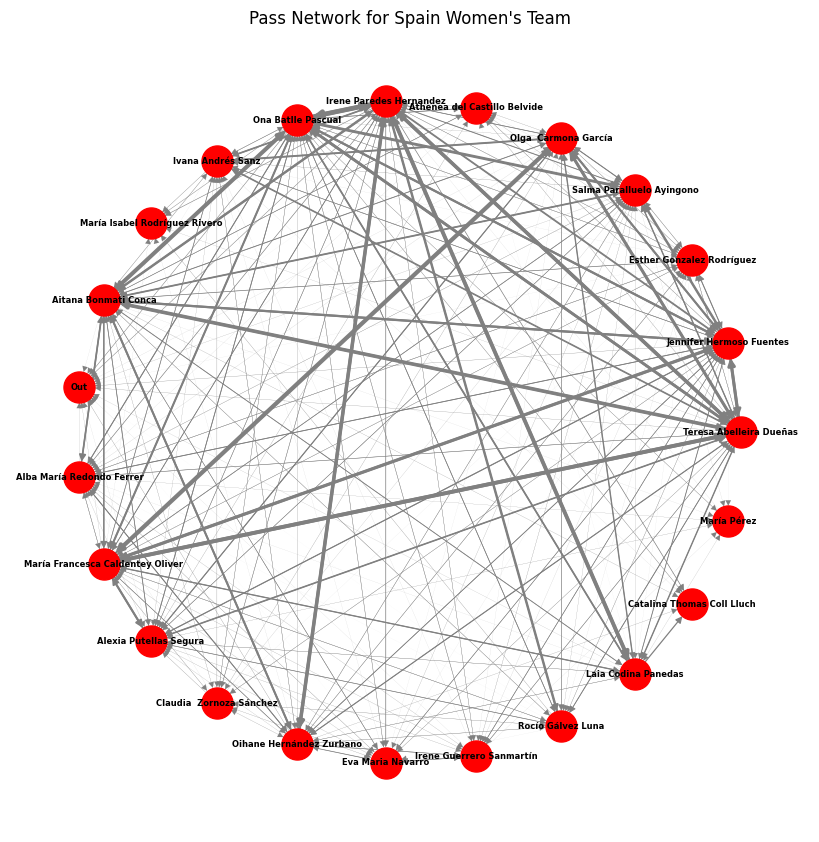

In [32]:
#Create empty graph for Spain analysis
G_team = nx.DiGraph()

#Edges are created with one edge between players and weight is sum of weights
for i, row in sna_team.iterrows():
    team_name = row['team_name']
    pass_recipient_team = row['pass_recipient_team']
    passer_name = row['player_name']
    pass_recipient = row['pass_recipient']
    position = row['poistion']
    pass_weight = row['complete_prob']

    pass_id = row['pass_id']
    
    #Edge weight increased for multiple passes
    if G_team.has_edge(passer_name, pass_recipient):
        G_team[passer_name][pass_recipient]['weight'] += pass_weight
    else:
        G_team.add_edge(passer_name, pass_recipient, weight=pass_weight, team_name = team_name, position = position)

edges = G_team.edges(data=True)
edge_widths = [edge[2]['weight'] *0.05 for edge in edges]

pos = nx.circular_layout(G_team)
#Plot graph
plt.figure(figsize=(8, 8))
nx.draw(G_team, pos, with_labels=True, node_size=500, node_color='red', font_size=6, font_weight='bold', 
        edge_color='grey', width=edge_widths)

plt.title("Pass Network for Spain Women's Team")
plt.show()

In [33]:
#Create df of edge details
edge_df = pd.DataFrame(edges, columns=['Passer', 'Reciever', 'Details'])

#Extract edge attributes from Details column
edge_df['Weight'] = edge_df['Details'].apply(lambda x: x['weight'])
edge_df['Team Name'] = edge_df['Details'].apply(lambda x: x['team_name'])
edge_df['Position'] = edge_df['Details'].apply(lambda x: x['position'])
edge_df = edge_df.drop(columns=['Details'])

#Sort by weight to see highest weighted pass connections
edge_df.sort_values(by='Weight', ascending=False).head(10)

,Passer,Reciever,Weight,Team Name,Position
100,Irene Paredes Hernandez,Ona Batlle Pascual,68.387181,Spain Women's,Right Center Back
127,Ona Batlle Pascual,Irene Paredes Hernandez,60.801073,Spain Women's,Right Back
80,Olga Carmona García,María Francesca Caldentey Oliver,60.774706,Spain Women's,Left Back
158,Aitana Bonmati Conca,Ona Batlle Pascual,58.212102,Spain Women's,Right Center Midfield
9,Teresa Abelleira Dueñas,María Francesca Caldentey Oliver,56.253632,Spain Women's,Center Defensive Midfield
119,Irene Paredes Hernandez,Laia Codina Panedas,55.610490,Spain Women's,Right Center Back
2,Teresa Abelleira Dueñas,Aitana Bonmati Conca,52.101168,Spain Women's,Center Defensive Midfield
197,María Francesca Caldentey Oliver,Teresa Abelleira Dueñas,51.905226,Spain Women's,Left Wing
105,Irene Paredes Hernandez,Teresa Abelleira Dueñas,51.524212,Spain Women's,Right Center Back
113,Irene Paredes Hernandez,Oihane Hernández Zurbano,50.961775,Spain Women's,Right Center Back


In [34]:
#Degree Centrality measure
degree_centrality_team = nx.degree_centrality(G_team)
degree_centrality_df_team = pd.DataFrame(degree_centrality_team.items(), columns=['Player', 'Degree Centrality'])
degree_centrality_df_team = degree_centrality_df_team.sort_values(by='Degree Centrality', ascending=False)

display(degree_centrality_df_team.head(5))

,Player,Degree Centrality
7,Ona Batlle Pascual,1.863636
6,Irene Paredes Hernandez,1.818182
1,Jennifer Hermoso Fuentes,1.727273
3,Salma Paralluelo Ayingono,1.681818
10,Aitana Bonmati Conca,1.681818


In [35]:
out_degree_team = dict(G_team.out_degree())
out_degree_df_team = pd.DataFrame.from_dict(out_degree_team, orient= 'index', columns=['Out-Degrees']).sort_values(by='Out-Degrees', ascending=False)
display(out_degree_df_team.head(10))

in_degree_team = dict(G_team.in_degree())
in_degree_df_team = pd.DataFrame.from_dict(in_degree_team, orient= 'index', columns=['In-Degrees']).sort_values(by='In-Degrees', ascending=False)
in_degree_df_team.head(10)

,Out-Degrees
Ona Batlle Pascual,22
Irene Paredes Hernandez,21
Jennifer Hermoso Fuentes,20
Aitana Bonmati Conca,20
Teresa Abelleira Dueñas,19
Salma Paralluelo Ayingono,19
Oihane Hernández Zurbano,19
María Francesca Caldentey Oliver,19
Olga Carmona García,17
Alexia Putellas Segura,17


,In-Degrees
Irene Paredes Hernandez,19
Ona Batlle Pascual,19
Out,18
Alexia Putellas Segura,18
Salma Paralluelo Ayingono,18
Alba María Redondo Ferrer,18
Jennifer Hermoso Fuentes,18
Aitana Bonmati Conca,17
María Francesca Caldentey Oliver,17
Teresa Abelleira Dueñas,17


In [36]:
# Betweenness Centrality measure
betweenness_centrality_team = nx.betweenness_centrality(G_team, weight='weight')
betweenness_centrality_df_team = pd.DataFrame(betweenness_centrality_team.items(), columns=['Player', 'Betweenness Centrality'])
betweenness_centrality_df_team = betweenness_centrality_df_team.sort_values(by='Betweenness Centrality', ascending=False)

betweenness_centrality_df_team.head(5)

,Player,Betweenness Centrality
12,Alba María Redondo Ferrer,0.183983
17,Eva Maria Navarro,0.177489
5,Athenea del Castillo Belvide,0.140693
18,Irene Guerrero Sanmartín,0.095238
22,María Pérez,0.077922


In [37]:
# Closeness centrality measure
closeness_centrality_team = nx.closeness_centrality(G_team)
closeness_centrality_df_team = pd.DataFrame(closeness_centrality_team.items(), columns=['Player', 'Closeness Centrality'])
closeness_centrality_df_team = closeness_centrality_df_team.sort_values(by='Closeness Centrality', ascending=False)

closeness_centrality_df_team.head(5)

,Player,Closeness Centrality
6,Irene Paredes Hernandez,0.863636
7,Ona Batlle Pascual,0.863636
11,Out,0.826446
14,Alexia Putellas Segura,0.820455
3,Salma Paralluelo Ayingono,0.820455


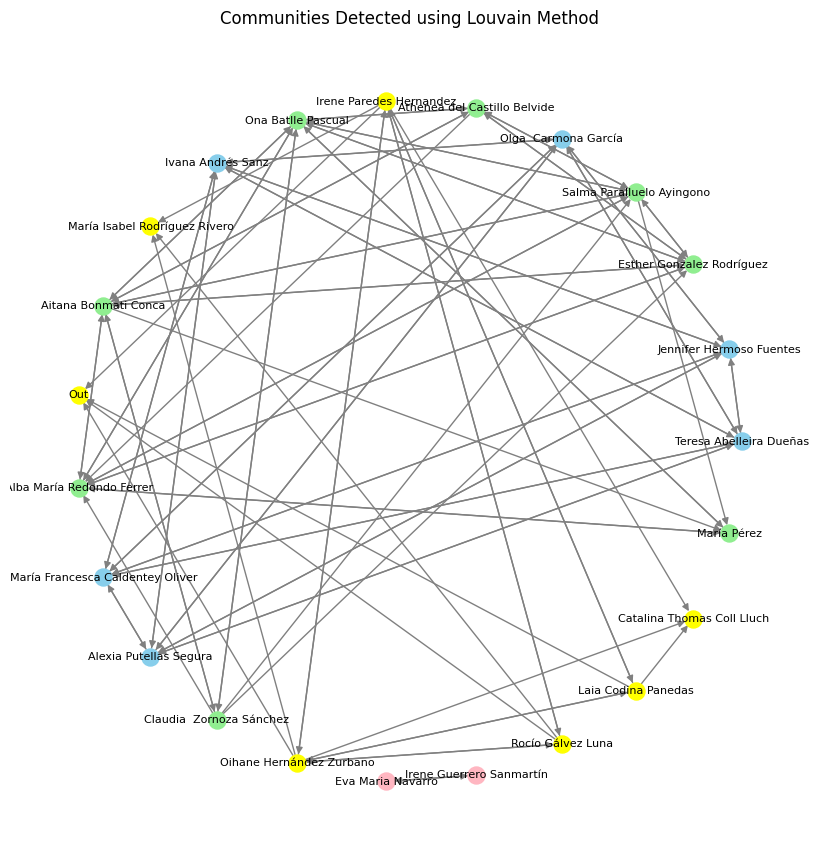

In [38]:
partition = community_louvain.best_partition(G_team.to_undirected(), weight='weight')

#Create communities based on the partition above
louvain_communities = {}
for player, community in partition.items():
    if community not in louvain_communities:
        louvain_communities[community] = []
    louvain_communities[community].append(player)

#Plot communities
colors = ['skyblue', 'lightgreen', 'yellow', 'lightpink', 'red']
plt.figure(figsize=(8, 8))
pos = nx.circular_layout(G_team)
for i, community in enumerate(louvain_communities.values()):
    subgraph = G_team.subgraph(community)
    nx.draw(subgraph, pos, with_labels=True, node_color=colors[i % len(colors)], 
            node_size=150, edge_color='gray', font_size=8)

plt.title('Communities Detected using Louvain Method')
plt.show()

In [39]:
#Every unique player and show the position
unique_players = sna_team['player_name'].unique()
for player in unique_players:
    #Use first occurence of player and position
    position = sna_team[sna_team['player_name'] == player]['poistion'].iloc[0]
    print(f"Player: {player}, Position: {position}")

Player: Teresa Abelleira Dueñas, Position: Center Defensive Midfield
Player: Jennifer Hermoso Fuentes, Position: Left Center Midfield
Player: Esther Gonzalez Rodríguez, Position: Center Forward
Player: Salma Paralluelo Ayingono, Position: Left Wing
Player: Olga  Carmona García, Position: Left Back
Player: Athenea del Castillo Belvide, Position: Right Wing
Player: Irene Paredes Hernandez, Position: Right Center Back
Player: Ona Batlle Pascual, Position: Right Back
Player: Ivana Andrés Sanz, Position: Left Center Back
Player: Aitana Bonmati Conca, Position: Right Center Midfield
Player: María Francesca Caldentey Oliver, Position: Left Wing
Player: Alba María Redondo Ferrer, Position: Center Forward
Player: Alexia Putellas Segura, Position: Right Wing
Player: Claudia  Zornoza Sánchez, Position: Center Defensive Midfield
Player: Oihane Hernández Zurbano, Position: Right Back
Player: Eva Maria Navarro, Position: Right Wing
Player: Irene Guerrero Sanmartín, Position: Right Center Midfield
Pl